In [1]:
import pandas as pd
import numpy as np

In [16]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
# from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import statsmodels.api as sm
import json

In [5]:
data=pd.read_excel("TSLA.xlsx",index_col=0,engine='openpyxl')

#dropping the null and undefined format
a='%Y-%m-%d %H:%M:%S'
data.time=pd.to_datetime(data.time,format=a,errors='coerce')
data=data[data['time'].notna()]


In [6]:
data

,time,open,high,low,close,volume
0,2021-08-20 20:00:00,680.2,680.3,680.0,680.3,1357
1,2021-08-20 19:55:00,680.1,680.2,680.1,680.12,1247
2,2021-08-20 19:50:00,679.9,680.0,679.9,680.0,1039
3,2021-08-20 19:45:00,679.9,679.9,679.8,679.8,1444
4,2021-08-20 19:40:00,679.9999,680.0,679.9999,680.0,590
...,...,...,...,...,...,...
45017,2020-08-28 04:50:00,453.602,453.602,453.54,453.54,2855
45018,2020-08-28 04:35:00,454.012,454.012,454.0,454.0,3715
45019,2020-08-28 04:25:00,453.558,453.558,453.558,453.558,1370
45020,2020-08-28 04:10:00,452.0,452.0,452.0,452.0,1855


In [ ]:
data=data[::-1].reset_index(drop=True)
data

In [ ]:
#plot close price
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(pd.to_numeric(data['close']))
plt.title('TSLA closing price')
plt.show()

In [ ]:
data['close']

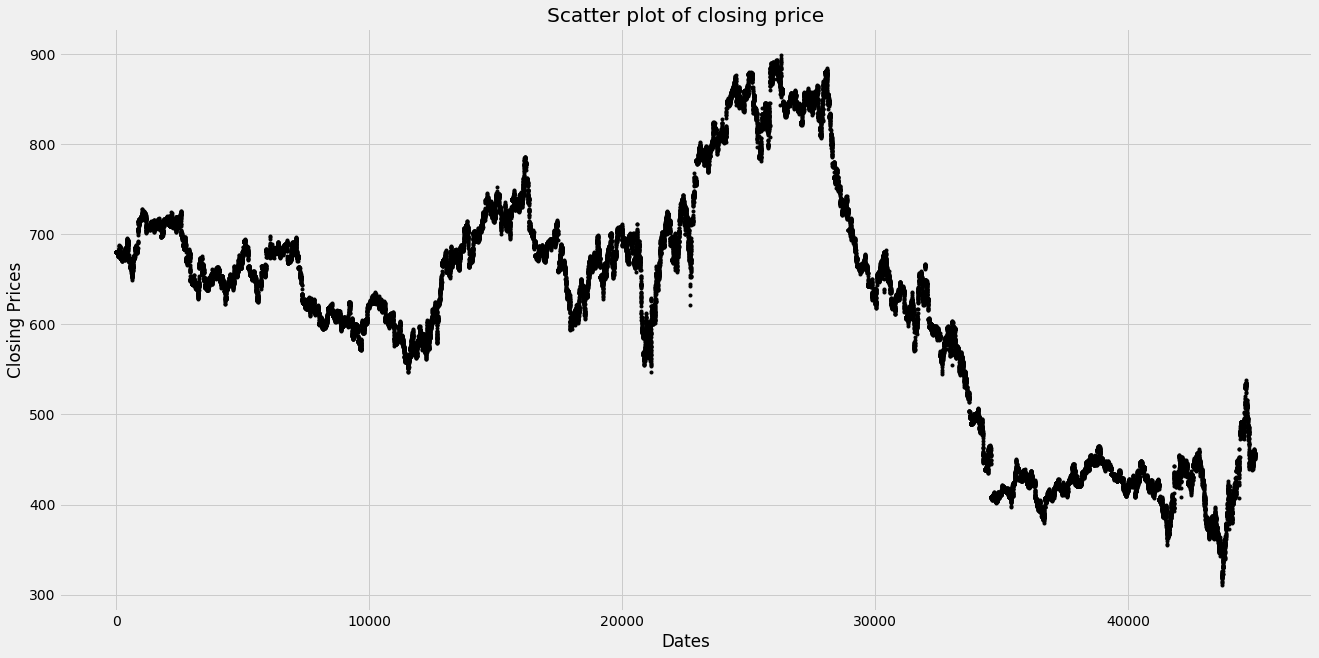

In [7]:
#plot close price  scatter plot
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
df_close = pd.to_numeric(data['close'])
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [ ]:
#change to proper data type
data[["open", "high","low","close","volume"]] = data[["open", "high","low","close","volume"]].apply(pd.to_numeric)

In [ ]:
data.describe()

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

**These components are defined as follows:**

**Level**: The average value in the series.

**Trend**: The increasing or decreasing value in the series.

**Seasonality**: The repeating short-term cycle in the series.

**Noise**: The random variation in the series.

**First, we need to check if a series is stationary or not because time series analysis only works with stationary data.**

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

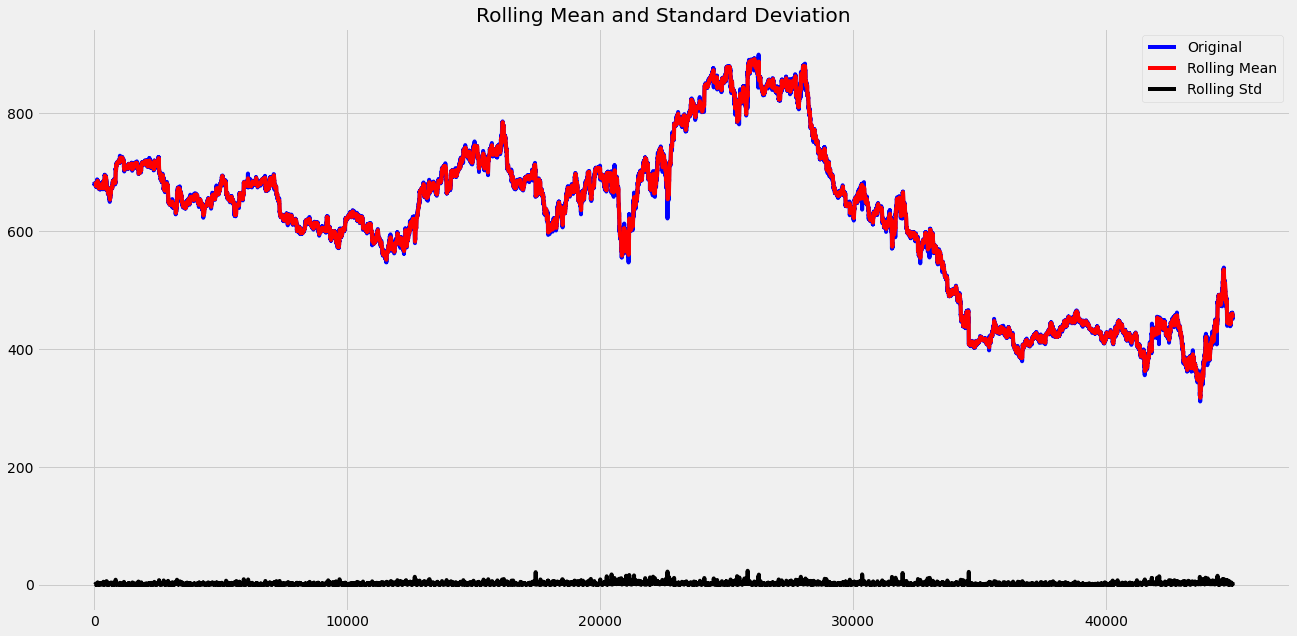

Results of dickey fuller test
Test Statistics                   -1.042989
p-value                            0.737264
No. of lags used                  30.000000
Number of observations used    44980.000000
critical value (1%)               -3.430495
critical value (5%)               -2.861604
critical value (10%)              -2.566804
dtype: float64
----------------------------------------------------------------------------------------------------
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
#Test for staionarity

#Ho: It is non stationary
#H1: It is stationary

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print('-'*100)
    if output['p-value'] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
test_stationarity(df_close)

**In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.**

<Figure size 720x432 with 0 Axes>

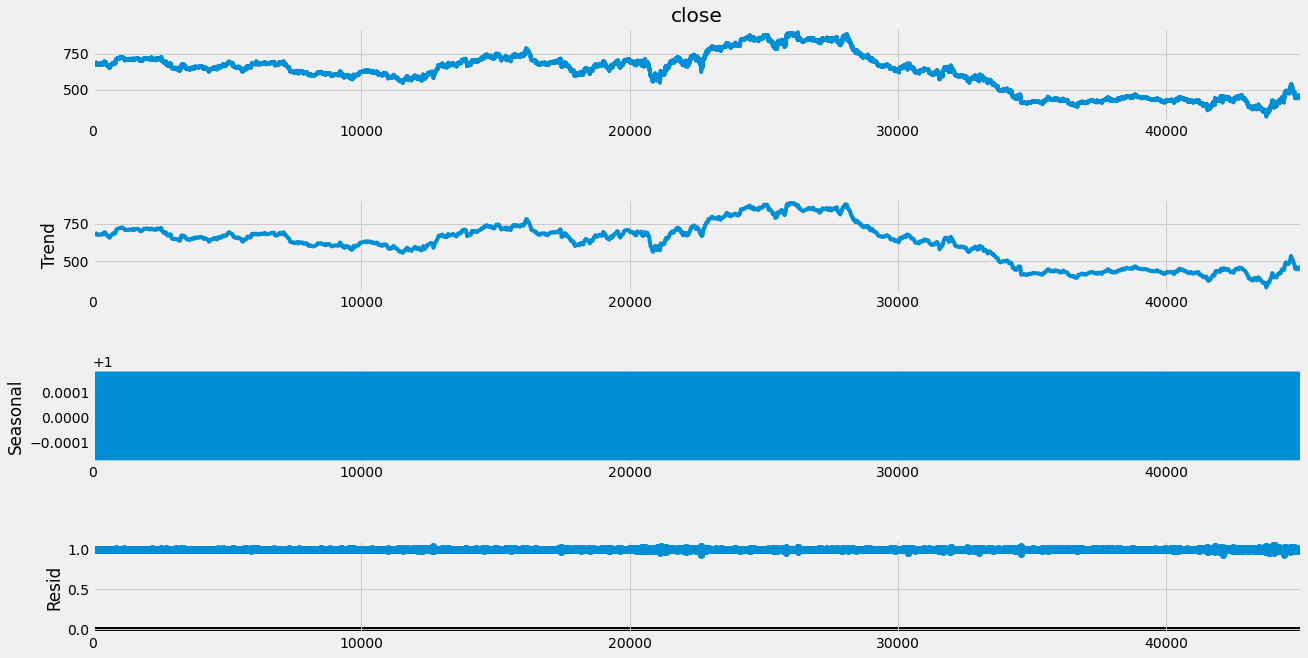

In [12]:
result = seasonal_decompose(df_close, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 10)

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


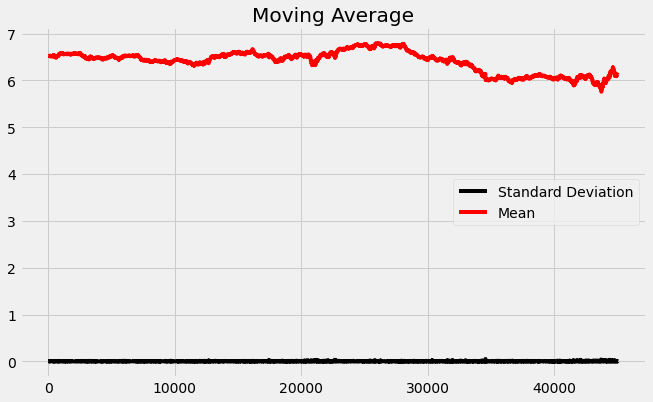

In [13]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

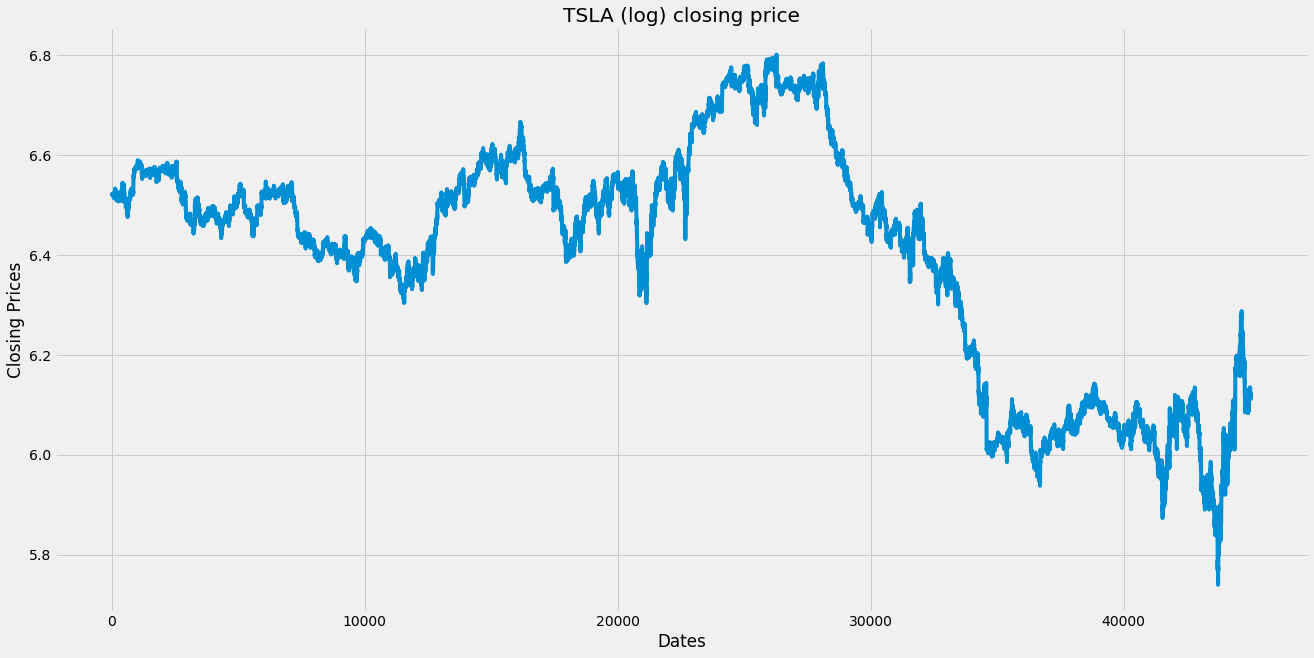

In [14]:
#plot log close price
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log)
plt.title('TSLA (log) closing price')
plt.show()

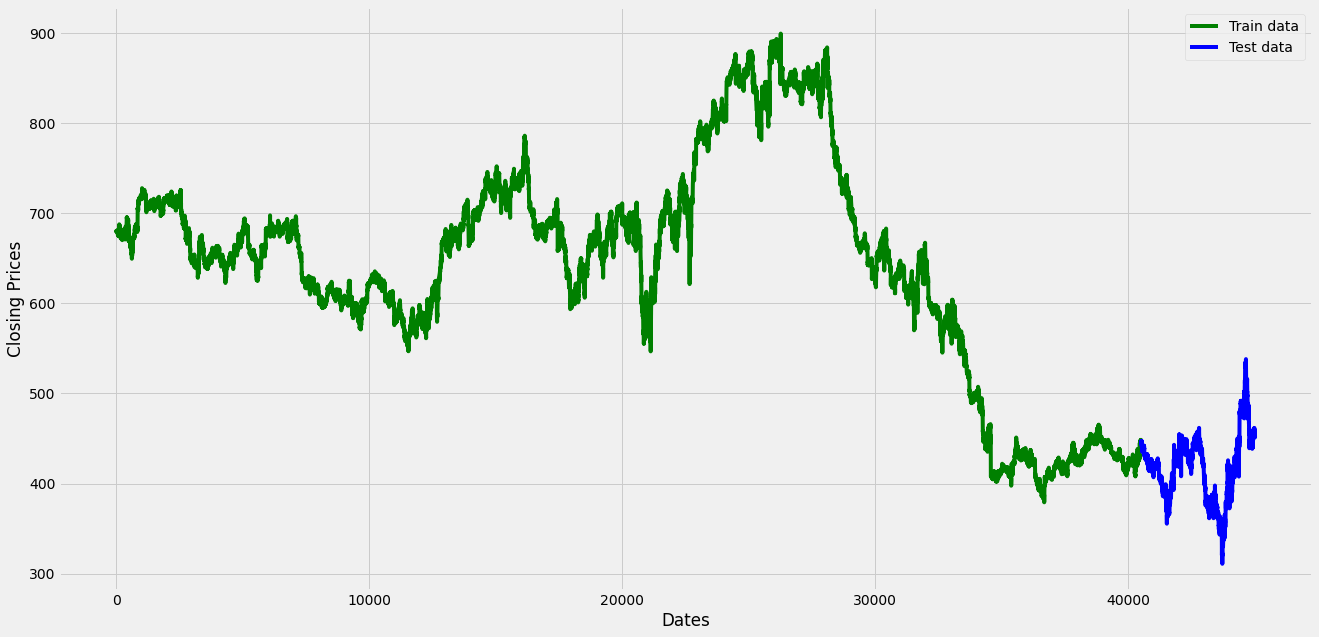

In [15]:
#split data into train and training set
train_data, test_data = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
complete_data=df_close
complete_data

In [ ]:
test_data

In [ ]:
model_autoARIMA = auto_arima(complete_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

In [ ]:
print(model_autoARIMA.summary())

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
model_info=model_autoARIMA.to_dict()
model_info
with open('ARIMA_model_TSLA.json','w') as fp:
    json.dump(model_info,fp,cls=NumpyEncoder)

In [ ]:
with open('ARIMA_model_TSLA.json','r') as fp:
    file=json.load(fp)
order=tuple(file['order'])

In [ ]:
order

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(complete_data, order=order)  
fitted = model.fit(disp=-1)  
print(fitted.summary())

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(4502, alpha=0.05)  # 95% confidence
print(fc)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

In [ ]:
fitted.save("TSLA_Arima_model.pkl")

In [ ]:
loaded_model=ARIMAResults.load("TSLA_Arima_model.pkl")

In [ ]:
fc, se, conf = loaded_model.forecast(steps=10)

In [ ]:
fc

In [ ]:
loaded_model.model.fit()

In [ ]:
data=[          [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700],
           [600, 700, 600, 700]]

In [ ]:
close=[]
i=0
for item in data:
    item[3]=item[3]+i

    i=i+1

In [ ]:
data

In [ ]:
input_df=pd.DataFrame(close,columns=['close'])

In [ ]:
inputx=input_df['close']

In [ ]:
inputx

In [ ]:
model=ARIMA(inputx,order=(2,1,2))
fitted=model.fit(disp=-1)

In [ ]:
fc,s,conf=fitted.forecast(steps=10)